### 练习三： 神经网络
原文的练习要求在[这里](ex3.pdf),要求用m文件进行编写。该练习使用python进行编程，为对更好的进行练习，没有完全和原代码进行想适应。

### 3.1 多级分类
简要描述：
> 在本练习中，将使用逻辑回归和神经网络来识别手写数字（从0到9）。 自动手写数字识别在今天被广泛使用，从识别邮件信封上的邮政编码（邮政编码）到识别银行支票上的金额。 本练习将展示如何将所学的方法用于此分类任务。   

####  3.1.1 读取数据集以及可视化数据 
本模板将会展示如何读取.mat文件的数据。此次数据集[ex3data1.mat](ex3data1.mat)包含5000个手写数字的训练样本。你可以调用函数读取数据（矩阵形式），数据将加载在内存中。该数据集已经命名好对应的不同的数字。让我们进行读取并对其中一些数据进行可视化吧。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib
import scipy.optimize as opt
% matplotlib inline

In [2]:
data = sio.loadmat("ex3data1.mat")
train_X = data["X"]
train_y = data["y"]
print (train_X.shape,train_y.shape)
print train_X[1].shape

((5000L, 400L), (5000L, 1L))
(400L,)


In [9]:
train_X[0].max(),train_X[0].min()

(1.0474834563069852, -0.057515114379085359)

In [3]:
# 可视化手写数字对应的图片
def plot_digit(imgs, nrows, ncols, figsize=None):
    """plot a list of images"""
    sample_idx = np.random.choice(np.arange(imgs.shape[0]), 100)  # 100*400
    sample_images = imgs[sample_idx, :]
    
    if not figsize:
        figsize = (ncols, nrows)
    _, figs = plt.subplots(nrows, ncols, figsize=figsize)
    for i in range(nrows):
        for j in range(ncols):
            data = sample_images[ncols * i + j].reshape((20,20)).T
            figs[i, j].imshow(data)        
    plt.show()    

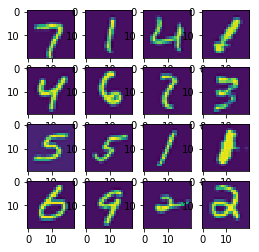

(400L,)

In [4]:
plot_digit(train_X,4,4)
train_X[0].shape

#### 3.1.2 矢量化Logistic回归
首先，我们先矢量化损失函数：
$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}$  
其中，${{h}_{\theta }}\left( {{x}^{(i)}} \right)$ = $g\left(  {{\theta}^{T}}{{x}^{(i)}} \right)$ 并且$g\left( z \right)=\frac{1}{1+{{e}^{-z}}}$   
这里我们来定义函数实现(这里我们直接正则化)

In [5]:
def sigmoid(Z):
    A = 1.0/(1+np.exp(-Z))
    return A

def cost(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (learningRate / (2 * len(X))) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(first - second) / len(X) + reg

#### 3.1.3 梯度下降

In [6]:
def gradient(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    error = sigmoid(X * theta.T) - y
    
    grad = ((X.T * error) / len(X)).T + ((learningRate / len(X)) * theta)
    
    # intercept gradient is not regularized
    grad[0, 0] = np.sum(np.multiply(error, X[:,0])) / len(X)
    
    return np.array(grad).ravel()

#### 3.1.4 构建分类器
现在我们已经定义好了损失函数和梯度下降了。现在要进行构建分类器...  
对于此次任务是要进行分类10类。在之前的练习过程中，一般使用的是逻辑回归，是针对两类回归问题，在这里我们需要采用多分类的策略。  
 在本练习中，我们的任务是实现一对一全分类方法，其中具有k个不同类的标签就有k个分类器，每个分类器在“类别 i”和“不是 i”之间决定。 我们将把分类器训练包含在一个函数中，该函数计算10个分类器中的每个分类器的最终权重，并将权重返回为k X（n + 1）数组，其中n是参数数量。

In [7]:
from scipy.optimize import minimize

def one_vs_all(X, y, num_labels, learning_rate):
    rows = X.shape[0]
    params = X.shape[1]
    
    # k X (n + 1) array for the parameters of each of the k classifiers
    all_theta = np.zeros((num_labels, params + 1))
    
    # insert a column of ones at the beginning for the intercept term
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    
    # labels are 1-indexed instead of 0-indexed
    for i in range(1, num_labels + 1):
        theta = np.zeros(params + 1)
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = np.reshape(y_i, (rows, 1))
        
        # minimize the objective function
        fmin = minimize(fun=cost, x0=theta, args=(X, y_i, learning_rate), method='TNC', jac=gradient)
        all_theta[i-1,:] = fmin.x
    
    return all_theta

这里需要注意的几点：
- 我们为theta添加了一个额外的参数（与训练数据一列），以计算截距项（常数项）。 
- 其次，我们将y从类标签转换为每个分类器的二进制值（要么是类i，要么不是类i）。 
- 我们使用SciPy的较新优化API来最小化每个分类器的代价函数。
如果指定的话，API将采用目标函数，初始参数集，优化方法和jacobian（渐变）函数。 然后将优化程序找到的参数分配给参数数组。

实现向量化代码的一个更具挑战性的部分是正确地写入所有的矩阵，保证维度正确。

In [8]:
rows = data['X'].shape[0]
params = data['X'].shape[1]

all_theta = np.zeros((10, params + 1))

X = np.insert(data['X'], 0, values=np.ones(rows), axis=1)

theta = np.random.rand(params + 1)

y_0 = np.array([1 if label == 0 else 0 for label in data['y']])
y_0 = np.reshape(y_0, (rows, 1))

X.shape, y_0.shape, theta.shape, all_theta.shape

((5000L, 401L), (5000L, 1L), (401L,), (10L, 401L))

In [9]:
all_theta = one_vs_all(data['X'], data['y'], 10, 1)
all_theta

C:\Users\Techik\Anaconda2\envs\gluon\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
C:\Users\Techik\Anaconda2\envs\gluon\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply
C:\Users\Techik\Anaconda2\envs\gluon\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in power
C:\Users\Techik\Anaconda2\envs\gluon\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\Users\Techik\Anaconda2\envs\gluon\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
C:\Users\Techik\Anaconda2\envs\gluon\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


array([[ -4.84724713e+00,   0.00000000e+00,   0.00000000e+00, ...,
          8.90909213e-03,   2.88345476e-07,   0.00000000e+00],
       [ -5.55040789e+00,   0.00000000e+00,   0.00000000e+00, ...,
          7.31706822e-02,  -7.24888549e-03,   0.00000000e+00],
       [ -8.49748016e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -2.55374907e-04,  -2.00760699e-06,   0.00000000e+00],
       ..., 
       [ -1.32258210e+01,   0.00000000e+00,   0.00000000e+00, ...,
         -4.98511155e+00,   5.75576188e-01,   0.00000000e+00],
       [ -8.67119277e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -1.78033846e-01,   8.95830697e-03,   0.00000000e+00],
       [ -1.19481275e+01,   0.00000000e+00,   0.00000000e+00, ...,
          1.02178865e-03,   5.34798551e-05,   0.00000000e+00]])

In [10]:
def predict_all(X, all_theta):
    rows = X.shape[0]
    params = X.shape[1]
    num_labels = all_theta.shape[0]
    
    # same as before, insert ones to match the shape
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    
    # convert to matrices
    X = np.matrix(X)
    all_theta = np.matrix(all_theta)
    
    # compute the class probability for each class on each training instance
    h = sigmoid(X * all_theta.T)
    
    # create array of the index with the maximum probability
    h_argmax = np.argmax(h, axis=1)
    
    # because our array was zero-indexed we need to add one for the true label prediction
    h_argmax = h_argmax + 1
    
    return h_argmax

In [11]:
y_pred = predict_all(data['X'], all_theta)
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, data['y'])]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print ('accuracy = {0}%'.format(accuracy * 100))

accuracy = 97.64%


神经网络的模型：
![pic](../../images/nn_model.png)